In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from catboost import CatBoostRegressor
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_submissions():
    !kaggle competitions submissions playground-series-s3e11

In [4]:
def push_kaggle(filename):
    !kaggle competitions submit -c playground-series-s3e11 -f {filename} -m ""

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [7]:
train.drop(['id'], axis=1, inplace=True)

In [8]:
test.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

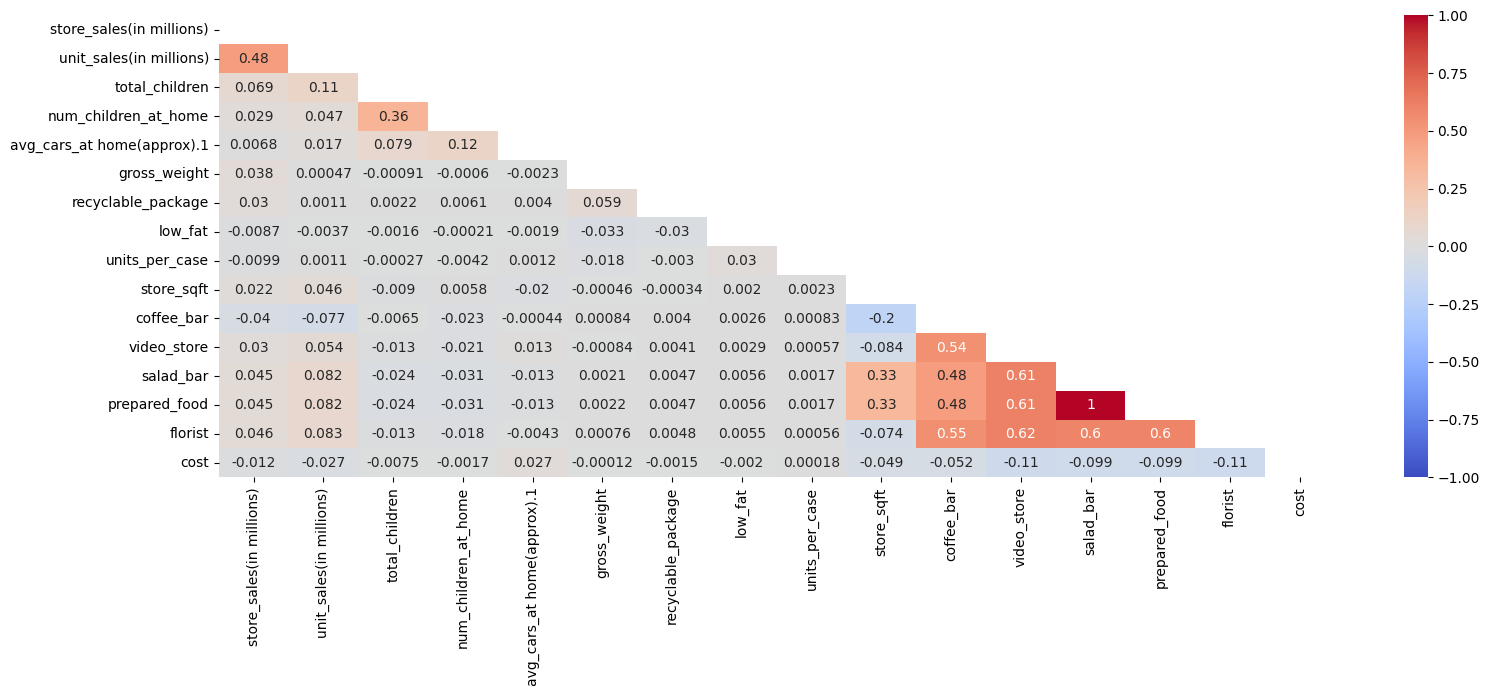

In [9]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [10]:
X_train = train.drop(['cost', 'prepared_food'], axis=1)
y_train = train[['cost']]
X_test = test.drop(['id', 'prepared_food'], axis=1)

In [11]:
for df in [X_train, X_test]:
    df['ratio'] = df.eval('total_children / num_children_at_home')
    df.replace([np.inf, -np.inf], 10, inplace = True)
    df.fillna(0, inplace = True)
    df['facilities'] = df.eval('coffee_bar + video_store + salad_bar + florist')
    df['independent_kid'] = df.eval('total_children - num_children_at_home')

In [12]:
y_train = np.log1p(y_train)

In [13]:
k = KFold(n_splits=5, random_state=0, shuffle=True)

In [20]:
def validate(model, X_train, y_train, X_test):
    val_predictions = np.zeros(len(train))
    predictions = np.zeros(len(test))
    train_scores, val_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(k.split(X_train, y_train)):
                
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        
        train_preds = model.predict(X_train.iloc[train_idx])
        val_preds = model.predict(X_train.iloc[val_idx])
        
        train_score = mean_squared_error(y_train.iloc[train_idx], train_preds, squared = False)
        val_score = mean_squared_error(y_train.iloc[val_idx], val_preds, squared = False)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f'Fold {fold}: val RMSLE = {val_score:.5f} | train RMSLE = {train_score:.5f}')

    print(f'Average val RMSLE = {np.mean(val_scores):.5f} | train RMSLE = {np.mean(train_scores):.5f}')

In [22]:
validate(
    Ridge(alpha=0.1, random_state=0),
    X_train, y_train, X_test
)

Fold 0: val RMSLE = 0.31333 | train RMSLE = 0.31339
Fold 1: val RMSLE = 0.31310 | train RMSLE = 0.31345
Fold 2: val RMSLE = 0.31296 | train RMSLE = 0.31348
Fold 3: val RMSLE = 0.31337 | train RMSLE = 0.31338
Fold 4: val RMSLE = 0.31419 | train RMSLE = 0.31318
Average val RMSLE = 0.31339 | train RMSLE = 0.31338


In [23]:
validate(
    LinearRegression(),
    X_train, y_train, X_test
)

Fold 0: val RMSLE = 0.31333 | train RMSLE = 0.31339
Fold 1: val RMSLE = 0.31310 | train RMSLE = 0.31345
Fold 2: val RMSLE = 0.31296 | train RMSLE = 0.31348
Fold 3: val RMSLE = 0.31337 | train RMSLE = 0.31338
Fold 4: val RMSLE = 0.31419 | train RMSLE = 0.31318
Average val RMSLE = 0.31339 | train RMSLE = 0.31338


In [24]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)
    
validate(
    xgb_model, X_train, y_train, X_test
)

Fold 0: val RMSLE = 0.29662 | train RMSLE = 0.28809
Fold 1: val RMSLE = 0.29637 | train RMSLE = 0.28811
Fold 2: val RMSLE = 0.29576 | train RMSLE = 0.28807
Fold 3: val RMSLE = 0.29569 | train RMSLE = 0.28812
Fold 4: val RMSLE = 0.29723 | train RMSLE = 0.28779
Average val RMSLE = 0.29633 | train RMSLE = 0.28803


In [25]:
params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **params
)
    
validate(
    catboost_model, X_train, y_train, X_test
)

Fold 0: val RMSLE = 0.29646 | train RMSLE = 0.29028
Fold 1: val RMSLE = 0.29612 | train RMSLE = 0.29068
Fold 2: val RMSLE = 0.29567 | train RMSLE = 0.29057
Fold 3: val RMSLE = 0.29547 | train RMSLE = 0.29049
Fold 4: val RMSLE = 0.29708 | train RMSLE = 0.29021
Average val RMSLE = 0.29616 | train RMSLE = 0.29045


In [20]:
#splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [21]:
X_train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,florist,ratio
120600,2.04,4.0,5.0,5.0,3.0,11.70,1.0,0.0,6.0,23759.0,1.0,0.0,1.0,1.0,1.0
209536,11.04,4.0,3.0,3.0,3.0,20.50,0.0,0.0,12.0,39696.0,0.0,0.0,1.0,0.0,1.0
90725,10.08,3.0,2.0,0.0,3.0,8.55,1.0,1.0,2.0,21215.0,1.0,0.0,0.0,0.0,10.0
265035,2.64,2.0,5.0,0.0,3.0,18.60,1.0,0.0,28.0,33858.0,1.0,0.0,1.0,1.0,10.0
39438,5.92,4.0,4.0,0.0,4.0,14.00,0.0,0.0,34.0,20319.0,0.0,0.0,0.0,0.0,10.0


In [22]:
X_train.dtypes

store_sales(in millions)       float64
unit_sales(in millions)        float64
total_children                 float64
num_children_at_home           float64
avg_cars_at home(approx).1     float64
gross_weight                   float64
recyclable_package             float64
low_fat                        float64
units_per_case                 float64
store_sqft                    category
coffee_bar                     float64
video_store                    float64
salad_bar                      float64
florist                        float64
ratio                          float64
dtype: object

In [59]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [61]:
def generate_csv(model, X_train, y_train, X_test, filename, y_transformed = False):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    output_df = test[['id']]
    if y_transformed:
        y_pred = np.expm1(y_pred)
    output_df['cost'] = y_pred
    output_df.to_csv(filename, index=False)
    print("Your submission was successfully saved!")

In [25]:
def get_score(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return mean_squared_log_error(y_val, y_pred)

In [26]:
y_train.head()

,cost
120600,4.509760
209536,4.426163
90725,4.938280
265035,4.108083
39438,4.782144


In [27]:
X_train_scaled

array([[0.06827309, 0.6       , 1.        , ..., 1.        , 1.        ,
        0.03571429],
       [0.46987952, 0.6       , 0.6       , ..., 1.        , 0.        ,
        0.03571429],
       [0.4270415 , 0.4       , 0.4       , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.18340027, 0.4       , 1.        , ..., 0.        , 0.        ,
        0.10714286],
       [0.06202588, 0.2       , 0.4       , ..., 1.        , 1.        ,
        1.        ],
       [0.49129853, 0.6       , 0.8       , ..., 1.        , 1.        ,
        1.        ]])

In [217]:
model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=1
)

get_score(
    model,
    X_train_scaled, y_train,
    X_val_scaled, y_val
)

0.09016808506840066

In [226]:
generate_csv(
    XGBRegressor(
        objective='reg:squarederror',
        tree_method='gpu_hist',
        gpu_id=0,
        subsample=0.8,
        n_estimators=600,
        min_child_weight=2,
        max_depth=9,
        learning_rate=0.01,
        gamma=0.1,
        colsample_bytree=1
    ),
    X_train_scaled, y_train, X_test_scaled, 'xgb.csv')

Your submission was successfully saved!


In [227]:
push_kaggle('xgb.csv')

100%|██████████████████████████████████████| 3.81M/3.81M [00:03<00:00, 1.02MB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [ ]:
# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [6, 8, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
# }

# catboost_model = CatBoostRegressor(
#     task_type="GPU",
#     devices='0:1'
# )

# halving_grid_search = HalvingGridSearchCV(
#     estimator=catboost_model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error', 
#     factor=3,
#     verbose=1,
#     cv=5,
# )

# halving_grid_search.fit(X_train_scaled, y_train)  # Replace X and y with your data

# # Get the best hyperparameters and estimator
# best_params = halving_grid_search.best_params_
# best_estimator = halving_grid_search.best_estimator_

In [220]:
params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
}

get_score(
    CatBoostRegressor(
        **params
    ),
    X_train_scaled, y_train,
    X_val_scaled, y_val
)

0:	learn: 29.7607718	total: 15ms	remaining: 2.98s
1:	learn: 29.6142482	total: 29.4ms	remaining: 2.91s
2:	learn: 29.4836691	total: 40.7ms	remaining: 2.67s
3:	learn: 29.3704195	total: 56.3ms	remaining: 2.76s
4:	learn: 29.2828973	total: 69.2ms	remaining: 2.7s
5:	learn: 29.2051992	total: 82.7ms	remaining: 2.67s
6:	learn: 29.1413643	total: 94.7ms	remaining: 2.61s
7:	learn: 29.0798494	total: 106ms	remaining: 2.55s
8:	learn: 29.0228661	total: 119ms	remaining: 2.52s
9:	learn: 28.9659775	total: 131ms	remaining: 2.49s
10:	learn: 28.9245684	total: 144ms	remaining: 2.48s
11:	learn: 28.8742320	total: 159ms	remaining: 2.48s
12:	learn: 28.8364963	total: 173ms	remaining: 2.49s
13:	learn: 28.7950942	total: 188ms	remaining: 2.5s
14:	learn: 28.7626738	total: 200ms	remaining: 2.47s
15:	learn: 28.7388556	total: 213ms	remaining: 2.45s
16:	learn: 28.7142960	total: 225ms	remaining: 2.43s
17:	learn: 28.6812118	total: 238ms	remaining: 2.41s
18:	learn: 28.6546284	total: 252ms	remaining: 2.4s
19:	learn: 28.633077

0.0902509641155506

In [183]:
catboost_model = CatBoostRegressor(
        task_type="GPU",
        devices='0:1',
        loss_function = 'RMSE',
        eval_metric = 'RMSE',
)

generate_csv(
    catboost_model,
    X_train_scaled, y_train,
    X_test_scaled,
    'catboost.csv'
)

Learning rate set to 0.084829
0:	learn: 29.8188852	total: 2.29ms	remaining: 2.29s
1:	learn: 29.7161254	total: 4.26ms	remaining: 2.13s
2:	learn: 29.6360484	total: 6.27ms	remaining: 2.08s
3:	learn: 29.5537844	total: 8.2ms	remaining: 2.04s
4:	learn: 29.4847111	total: 10.1ms	remaining: 2.02s
5:	learn: 29.4267222	total: 12ms	remaining: 1.99s
6:	learn: 29.3803424	total: 14ms	remaining: 1.99s
7:	learn: 29.3390174	total: 16ms	remaining: 1.98s
8:	learn: 29.3055492	total: 17.9ms	remaining: 1.98s
9:	learn: 29.2715326	total: 19.9ms	remaining: 1.97s
10:	learn: 29.2449220	total: 21.7ms	remaining: 1.95s
11:	learn: 29.2183555	total: 23.6ms	remaining: 1.94s
12:	learn: 29.1962725	total: 25.5ms	remaining: 1.93s
13:	learn: 29.1766070	total: 27.3ms	remaining: 1.92s
14:	learn: 29.1523640	total: 29.2ms	remaining: 1.91s
15:	learn: 29.1317295	total: 31.1ms	remaining: 1.91s
16:	learn: 29.1131110	total: 32.9ms	remaining: 1.9s
17:	learn: 29.0972093	total: 34.8ms	remaining: 1.9s
18:	learn: 29.0840797	total: 36.7ms

In [221]:
push_kaggle('catboost.csv')

100%|██████████████████████████████████████| 5.81M/5.81M [00:05<00:00, 1.14MB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [67]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=1
)

params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0
}

catboost_model = CatBoostRegressor(
    **params
)

stack_model = StackingRegressor([
    ('xgb', xgb_model),
    ('cb', catboost_model)
])

generate_csv(
    stack_model,
    X_train, y_train,
    X_test,
    'xgb+cb_stacked.csv',
    y_transformed= True
)

# validate(
#     stack_model, X_train, y_train, X_test
# )

0:	learn: 0.3145920	total: 23.3ms	remaining: 4.64s
1:	learn: 0.3128874	total: 46ms	remaining: 4.56s
2:	learn: 0.3113523	total: 74.8ms	remaining: 4.91s
3:	learn: 0.3101532	total: 108ms	remaining: 5.3s
4:	learn: 0.3090839	total: 134ms	remaining: 5.24s
5:	learn: 0.3082318	total: 161ms	remaining: 5.21s
6:	learn: 0.3074991	total: 186ms	remaining: 5.13s
7:	learn: 0.3066878	total: 206ms	remaining: 4.95s
8:	learn: 0.3060113	total: 227ms	remaining: 4.82s
9:	learn: 0.3055298	total: 250ms	remaining: 4.74s
10:	learn: 0.3050115	total: 272ms	remaining: 4.68s
11:	learn: 0.3046558	total: 296ms	remaining: 4.64s
12:	learn: 0.3042132	total: 317ms	remaining: 4.56s
13:	learn: 0.3038322	total: 341ms	remaining: 4.53s
14:	learn: 0.3032956	total: 364ms	remaining: 4.5s
15:	learn: 0.3029370	total: 390ms	remaining: 4.49s
16:	learn: 0.3026074	total: 412ms	remaining: 4.44s
17:	learn: 0.3023867	total: 434ms	remaining: 4.38s
18:	learn: 0.3020623	total: 460ms	remaining: 4.38s
19:	learn: 0.3018386	total: 491ms	remainin

In [68]:
push_kaggle('xgb+cb_stacked.csv')

100%|██████████████████████████████████████| 5.77M/5.77M [00:04<00:00, 1.32MB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [71]:
get_submissions()

fileName                 date                 description  status    publicScore  privateScore  
-----------------------  -------------------  -----------  --------  -----------  ------------  
xgbcb_stacked.csv        2023-10-03 14:45:15               complete  0.29527      0.29589       
xgbcb_stacked.csv        2023-10-03 14:43:05               complete  0.29527      0.29589       
xgbcb_stacked.csv        2023-10-02 12:39:19               complete  0.29586      0.29641       
xgbcb_stacked.csv        2023-09-28 13:05:05               complete  0.29898      0.29961       
xgb.csv                  2023-09-28 12:24:25               complete  0.29965      0.30054       
xgbcb_stacked.csv        2023-09-28 12:23:19               complete  0.29904      0.2998        
catboost.csv             2023-09-28 12:19:29               complete  0.30213      0.30303       
xgblinearcb_stacked.csv  2023-09-28 10:19:33               complete  0.30117      0.30205       
xgblinearcb_stacked.csv  2023-